# EhV: batch effect removal

# Package imports

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
%matplotlib inline

In [88]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [89]:
import copy
import pickle

In [90]:
import numpy
import scipy.stats
from scipy.cluster.hierarchy import cut_tree

from sklearn.feature_selection import mutual_info_classif

from kneed import KneeLocator

In [91]:
import scanpy
import anndata

# Data import

In [92]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [93]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

cols = numpy.load(data_dir / "indices/columns_v5.npy", allow_pickle=True)
cols = numpy.delete(cols, numpy.where(numpy.char.find(cols.astype("str"),"logicle")!=-1))
df = df[cols]

df = df.loc[numpy.load(data_dir / "indices/index_v5.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(100640, 907)

In [94]:
adata = anndata.AnnData(
    df.filter(regex="feat"), 
    obs=df.filter(regex="meta"),
    dtype=numpy.float32
)
adata.raw = adata

In [95]:
adata.X = adata.to_df().fillna(0)

# Initial removal of batch features

Features should not be able to distinguish healthy infected cells from healthy control cells

In [97]:
sel1 = (adata.obs.reset_index()["meta_type"] == "Ctrl") & (adata.obs.reset_index()["meta_label"] == "mcp-_psba+")
sel2 = (adata.obs.reset_index()["meta_type"] == "Inf") & (adata.obs.reset_index()["meta_label"] == "mcp-_psba+")

In [98]:
sum(sel1), sum(sel2)

(70585, 14475)

In [99]:
%%time
X = adata[sel1 | sel2].X
target = numpy.vstack([sel1, sel2]).argmax(axis=0)[sel1|sel2]

mi = mutual_info_classif(X, target, discrete_features=["euler" in c for c in adata.var_names], n_neighbors=30, random_state=0)
mi = pandas.Series(mi, index=adata.var_names).sort_values(ascending=False)

CPU times: user 12min 6s, sys: 20.5 s, total: 12min 26s
Wall time: 12min 30s


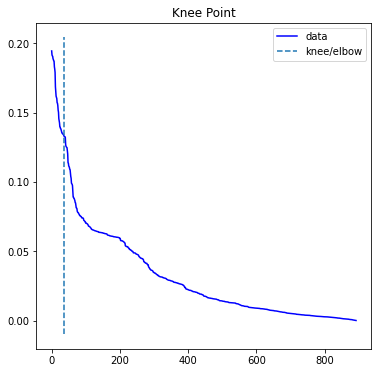

In [100]:
kneedle = KneeLocator(numpy.arange(len(mi)), mi, S=1, curve='convex', direction="decreasing",online=False)
elbow_value = mi.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [101]:
mi[mi > elbow_value].index.values

array(['feat_combined_mean_TMR', 'feat_combined_upper_quartile_TMR',
       'feat_combined_median_TMR', 'feat_combined_lower_quartile_TMR',
       'feat_combined_edge_mean_TMR',
       'feat_combined_edge_upper_quartile_TMR',
       'feat_combined_edge_median_TMR',
       'feat_combined_edge_lower_quartile_TMR', 'feat_combined_min_TMR',
       'feat_combined_edge_min_TMR', 'feat_combined_edge_max_TMR',
       'feat_combined_mean_BF2', 'feat_combined_median_BF2',
       'feat_combined_edge_median_BF2', 'feat_combined_edge_sum_TMR',
       'feat_combined_max_TMR', 'feat_combined_edge_lower_quartile_BF2',
       'feat_combined_edge_upper_quartile_BF2', 'feat_mean_BF2',
       'feat_combined_upper_quartile_BF2', 'feat_combined_edge_mean_BF2',
       'feat_median_BF2', 'feat_combined_lower_quartile_BF2',
       'feat_combined_sum_TMR', 'feat_combined_edge_max_BF2',
       'feat_mean_TMR', 'feat_upper_quartile_BF2', 'feat_median_TMR',
       'feat_lower_quartile_TMR', 'feat_upper_quartile_TM

<AxesSubplot:xlabel='feat_combined_mean_TMR', ylabel='Count'>

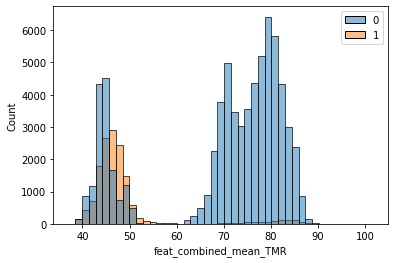

In [102]:
seaborn.histplot(data=adata[sel1 | sel2].to_df(), x="feat_combined_mean_TMR", hue=target)

<AxesSubplot:xlabel='meta_group', ylabel='count'>

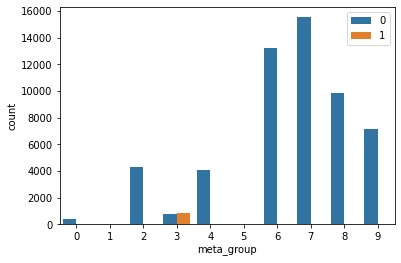

In [104]:
sel = adata[sel1 | sel2, "feat_combined_mean_TMR"].X.ravel() > 60
seaborn.countplot(data=adata[sel1 | sel2][sel].obs.reset_index(), x="meta_group", hue=target[sel])

In [105]:
%%time

X2 = adata[sel1 | sel2][~sel].X
target2 = target[~sel]

mi2 = mutual_info_classif(X2, target2, discrete_features=["euler" in c for c in adata.var_names], n_neighbors=30, random_state=0)
mi2 = pandas.Series(mi2, index=adata.var_names).sort_values(ascending=False)

CPU times: user 3min 31s, sys: 160 ms, total: 3min 32s
Wall time: 3min 33s


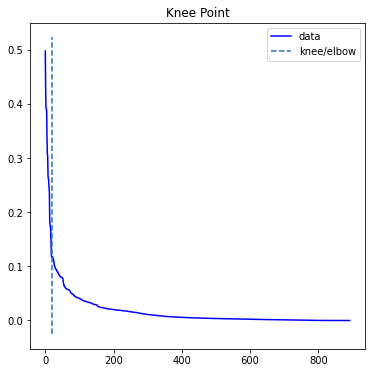

In [106]:
kneedle = KneeLocator(numpy.arange(len(mi2)), mi2, S=1, curve='convex', direction="decreasing",online=False)
elbow_value = mi2.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [107]:
mi2[mi2 > elbow_value].index.values

array(['feat_combined_mean_BF1', 'feat_mean_BF1',
       'feat_combined_upper_quartile_BF1',
       'feat_combined_edge_upper_quartile_BF1',
       'feat_combined_median_BF1', 'feat_combined_edge_median_BF1',
       'feat_combined_edge_max_BF1', 'feat_combined_edge_mean_BF1',
       'feat_median_BF1', 'feat_upper_quartile_BF1',
       'feat_lower_quartile_BF1', 'feat_combined_edge_lower_quartile_BF1',
       'feat_combined_lower_quartile_BF1', 'feat_edge_upper_quartile_BF1',
       'feat_edge_mean_BF1', 'feat_edge_median_BF1',
       'feat_edge_lower_quartile_BF1', 'feat_edge_max_BF1',
       'feat_combined_median_Cy5', 'feat_combined_edge_min_BF1'],
      dtype=object)

<AxesSubplot:xlabel='feat_combined_mean_BF1', ylabel='Count'>

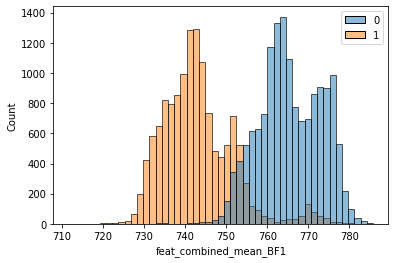

In [108]:
seaborn.histplot(data=adata[sel1 | sel2][~sel].to_df(), x="feat_combined_mean_BF1", hue=target2)

<AxesSubplot:xlabel='feat_combined_mad_Cy5', ylabel='Count'>

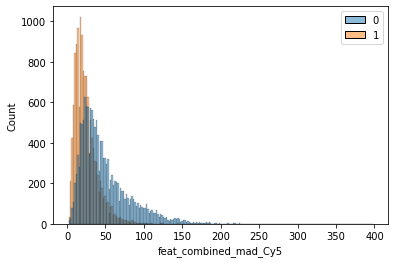

In [109]:
seaborn.histplot(data=adata[sel1 | sel2][~sel].to_df(), x="feat_combined_mad_Cy5", hue=target2)

<AxesSubplot:xlabel='feat_combined_median_Cy5', ylabel='Count'>

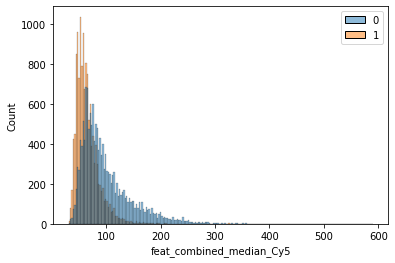

In [110]:
seaborn.histplot(data=adata[sel1 | sel2][~sel].to_df(), x="feat_combined_median_Cy5", hue=target2)

In [111]:
selected_mi = mi2[mi2 < elbow_value].index.values
len(selected_mi)

872

In [112]:
vec = numpy.arange(len(adata))[sel1|sel2][sel]
idx = numpy.delete(numpy.arange(len(adata)), vec)

In [113]:
numpy.save(data_dir / "indices/index_batch_v2.npy", adata.obs.iloc[idx].index)
numpy.save(data_dir / "indices/columns_batch_v2.npy", selected_mi.tolist() + adata.obs.columns.tolist())